In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

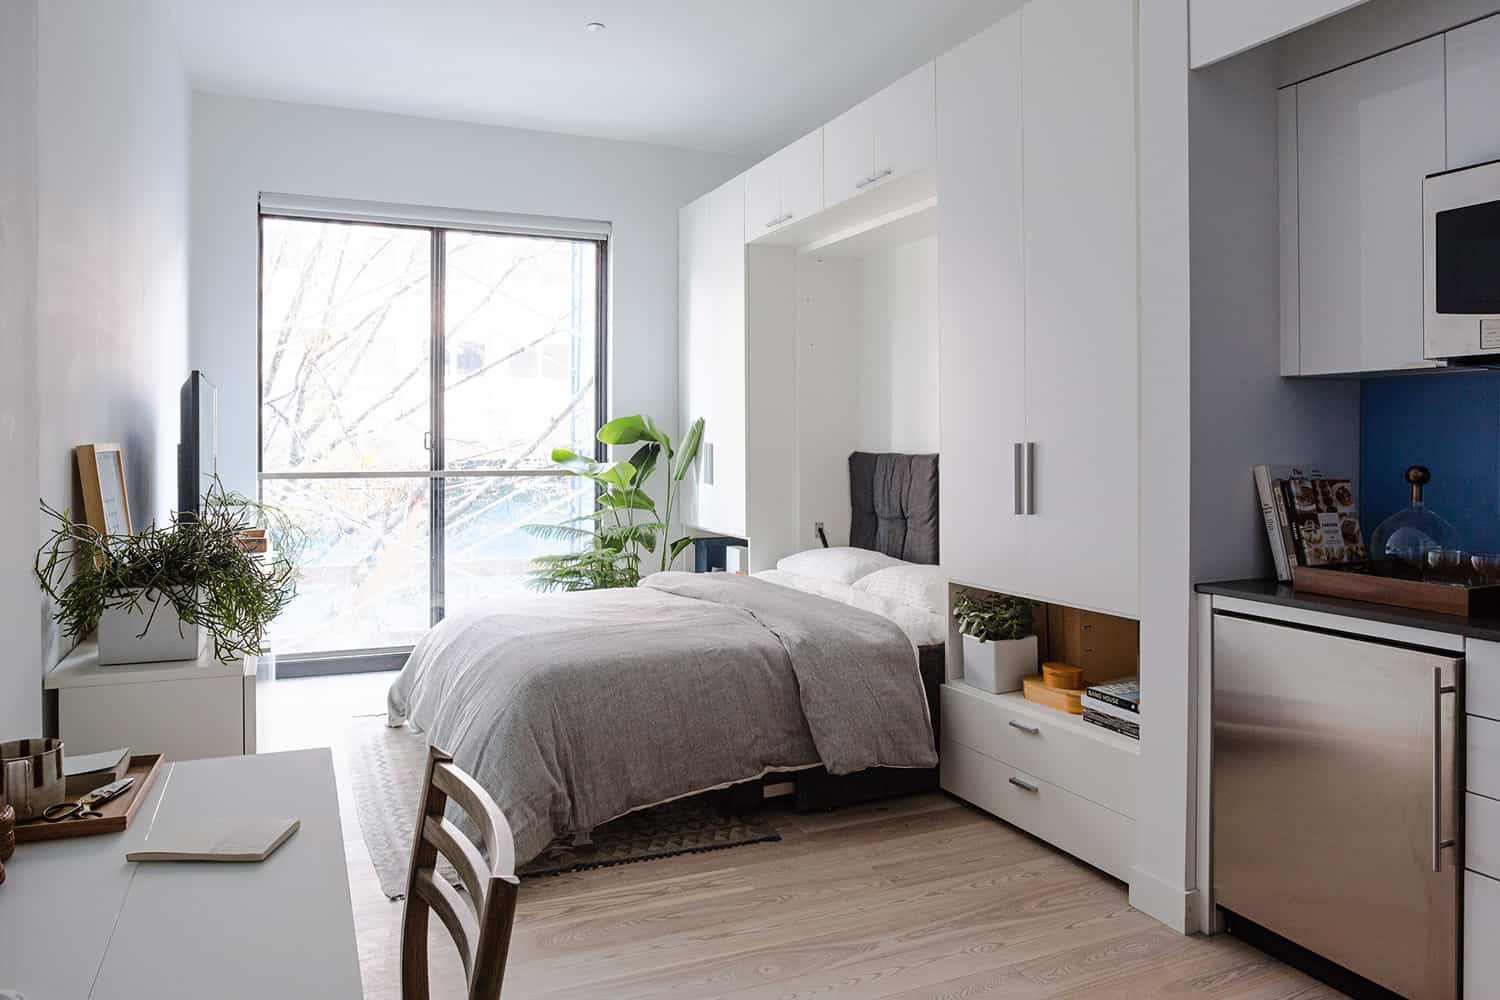

In [36]:
image = Image.open("/home/nader/DesignGenie/assets/images/sample_2.jpg")
image

## SAM Model

In [9]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam = sam_model_registry["vit_l"](checkpoint="/home/nader/DesignGenie/checkpoints/sam_vit_l_0b3195.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [13]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

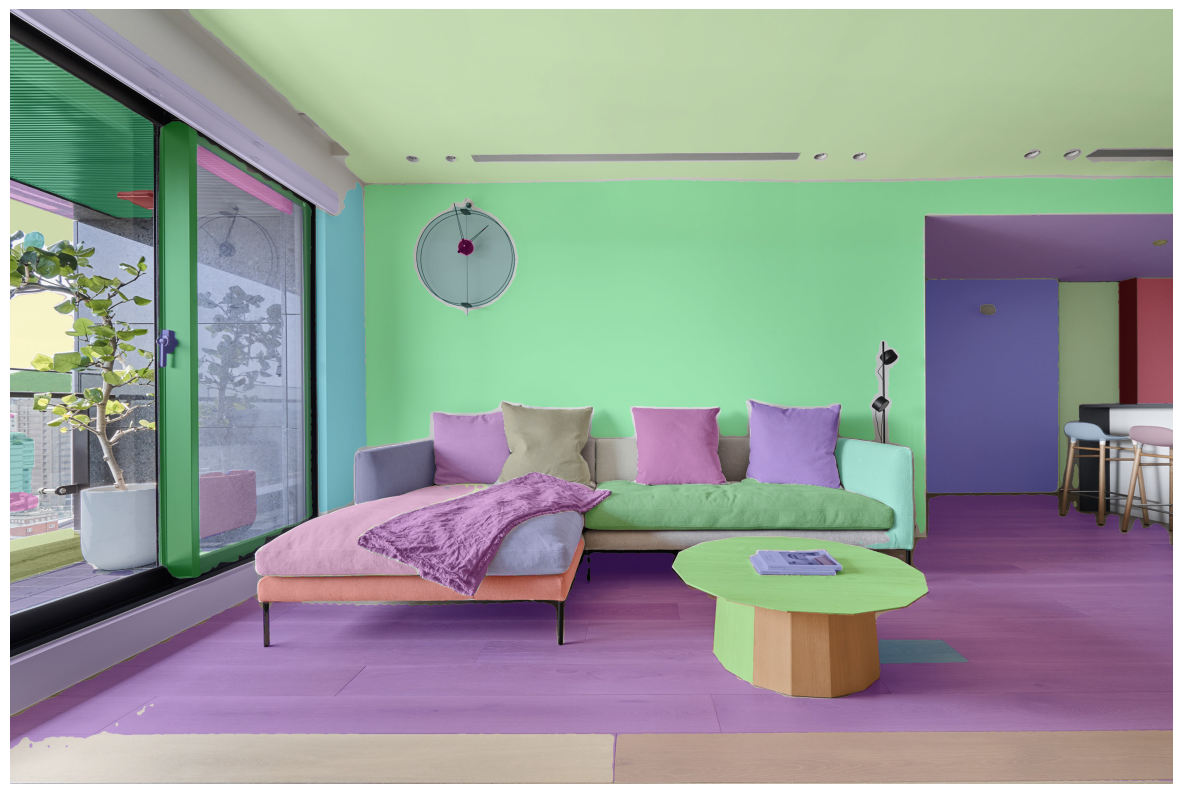

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## HuggingFace Models

### ADE21K Palette

In [32]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]
     

In [33]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

def visualize_segmentation_map(seg):
    # Convert to RGB
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)


    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(img)

### SegFormer

In [26]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# image = Image.open("/home/nader/DesignGenie/assets/images/sample_1.jpg")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


### MaskFormer

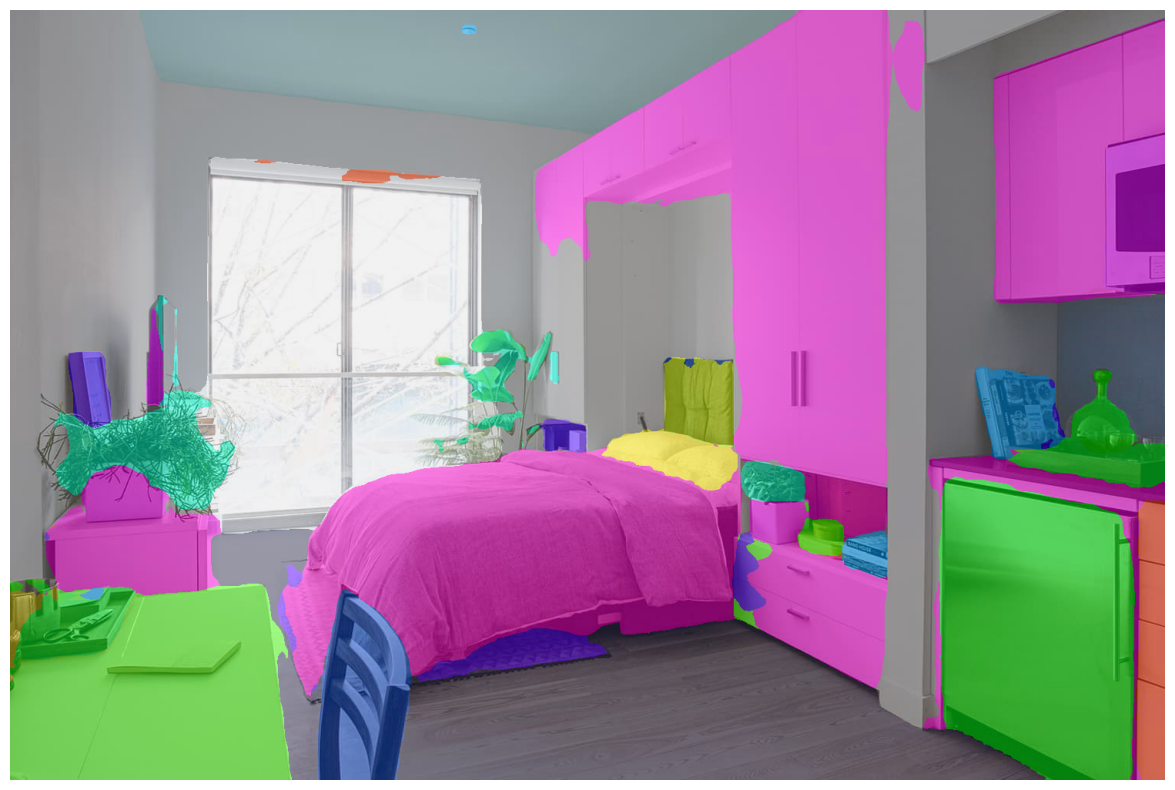

In [39]:
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# url = "/home/nader/DesignGenie/assets/images/sample_1.jpg"
# image = Image.open("/home/nader/DesignGenie/assets/images/sample_1.jpg")

processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-large-ade")
inputs = processor(images=image, return_tensors="pt")

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade")
outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

visualize_segmentation_map(predicted_semantic_map)

### Mask2Former

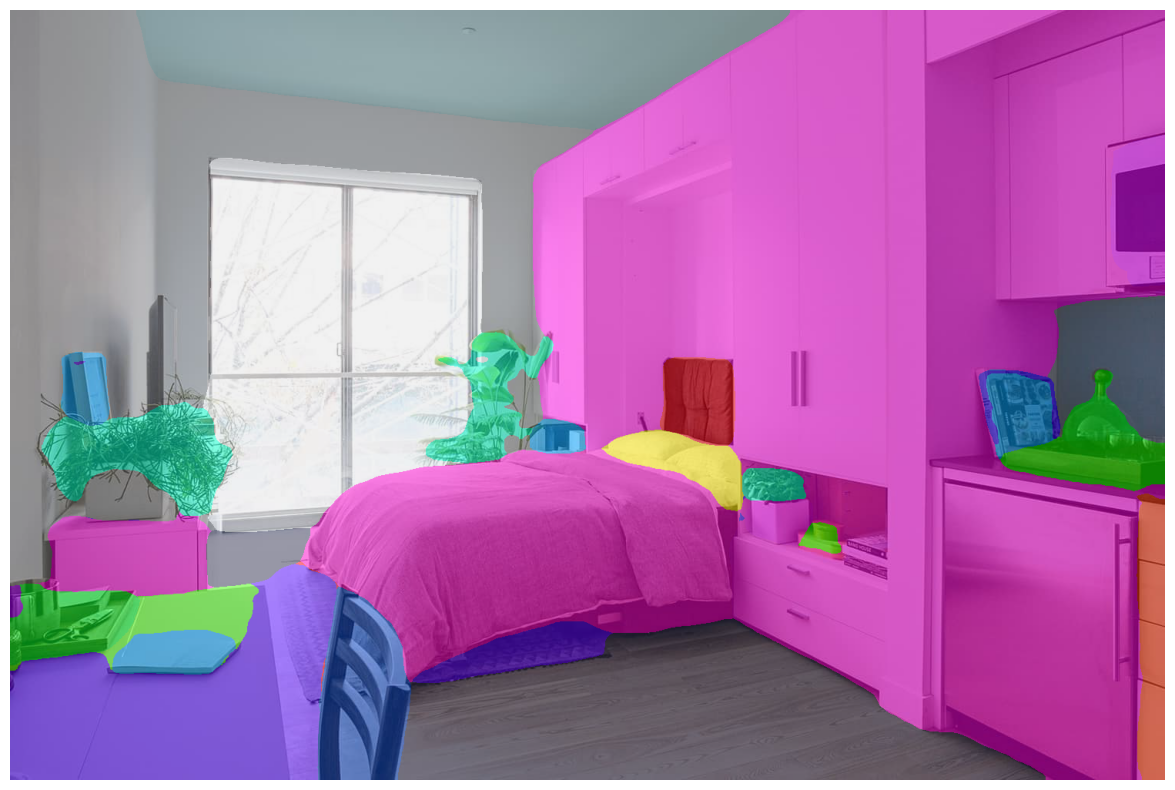

In [41]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import requests


processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
inputs = processor(images=image, return_tensors="pt")

model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

visualize_segmentation_map(predicted_semantic_map)

### OneFormer

/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/transformers/models/oneformer/image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


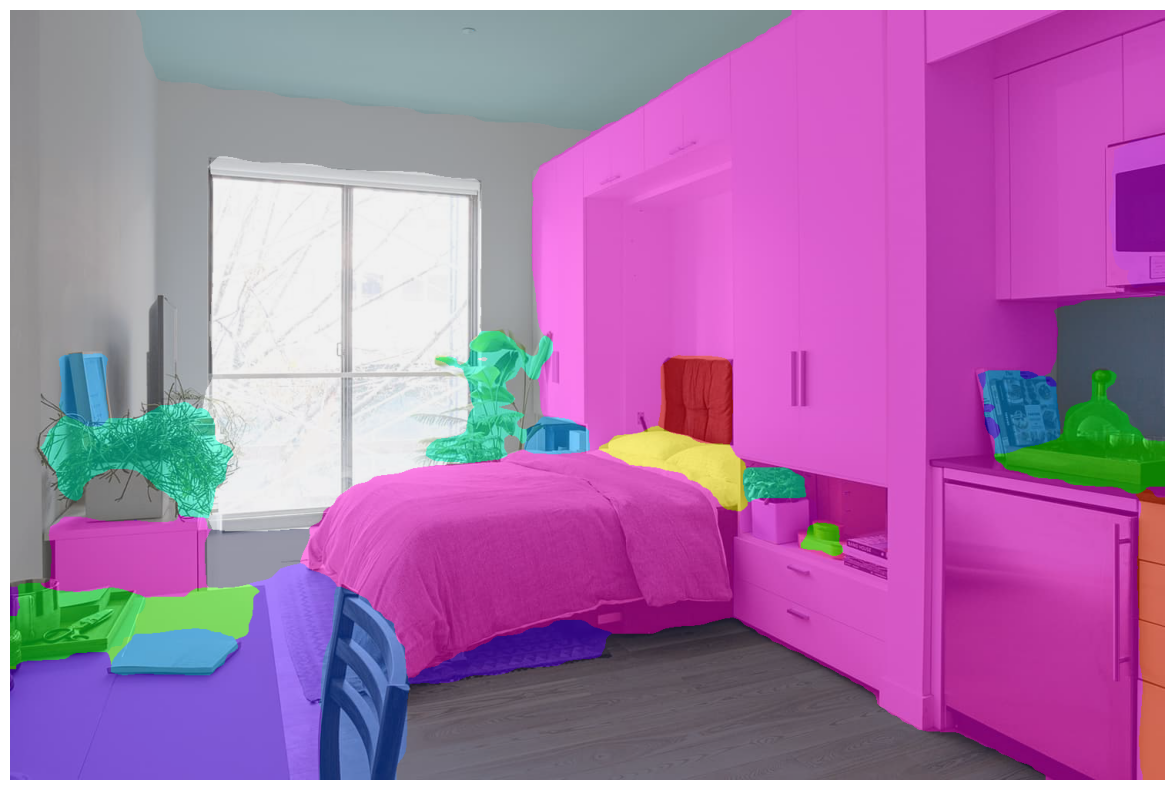

In [38]:
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image


# Loading a single model for all three tasks
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")

# Semantic Segmentation
semantic_inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
semantic_outputs = model(**semantic_inputs)
# pass through image_processor for postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

visualize_segmentation_map(predicted_semantic_map)

## Segmentation Map to Mask

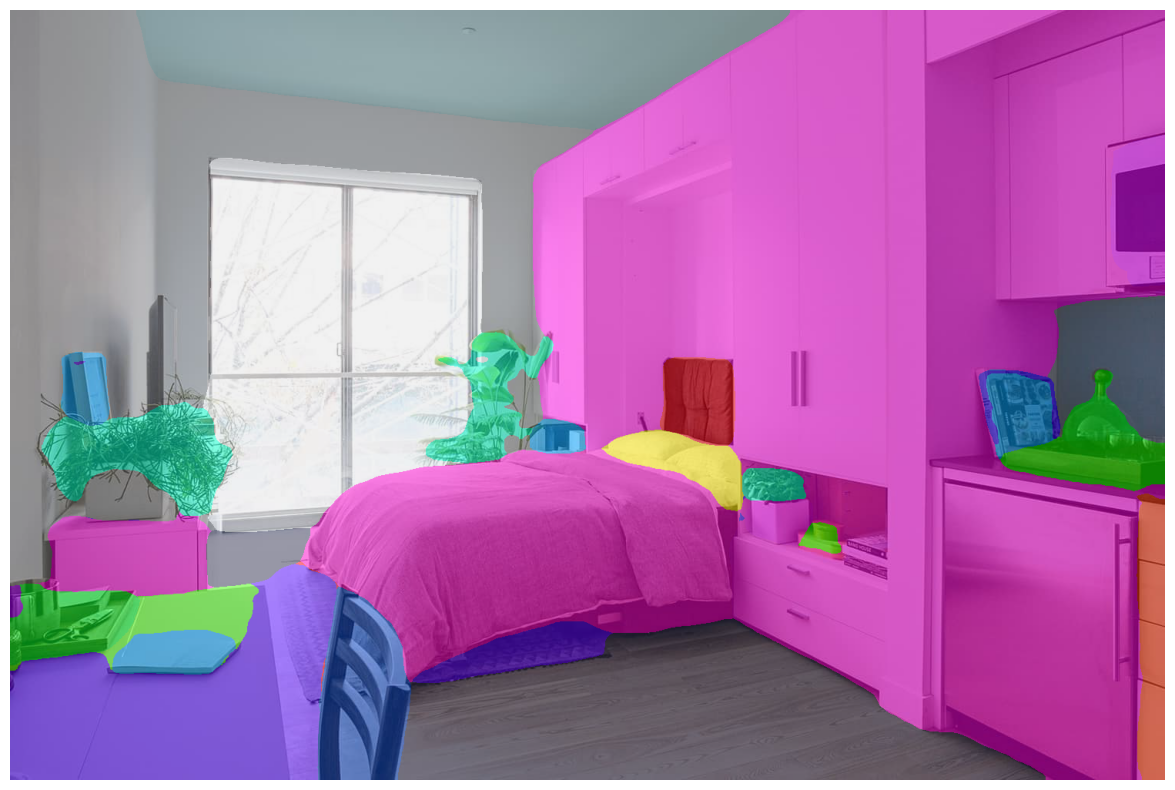

In [42]:
visualize_segmentation_map(predicted_semantic_map)

In [46]:
predicted_semantic_map

tensor([[ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        ...,
        [15, 15, 15,  ..., 44, 44, 44],
        [15, 15, 15,  ..., 44, 44, 44],
        [15, 15, 15,  ..., 44, 44, 44]])

In [76]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

def mask_segmentation_map(seg_map: torch.Tensor):
    masks = []
    labels = []
    for label, color in enumerate(np.array(ade_palette())):
        mask = np.ones((seg_map.shape[0], seg_map.shape[1]), dtype=np.uint8) # height, width
        indices = (seg_map == label)
        mask[indices] = 0

        if indices.sum() > 0:
            masks.append(mask)
            labels.append(label)

    return masks, labels

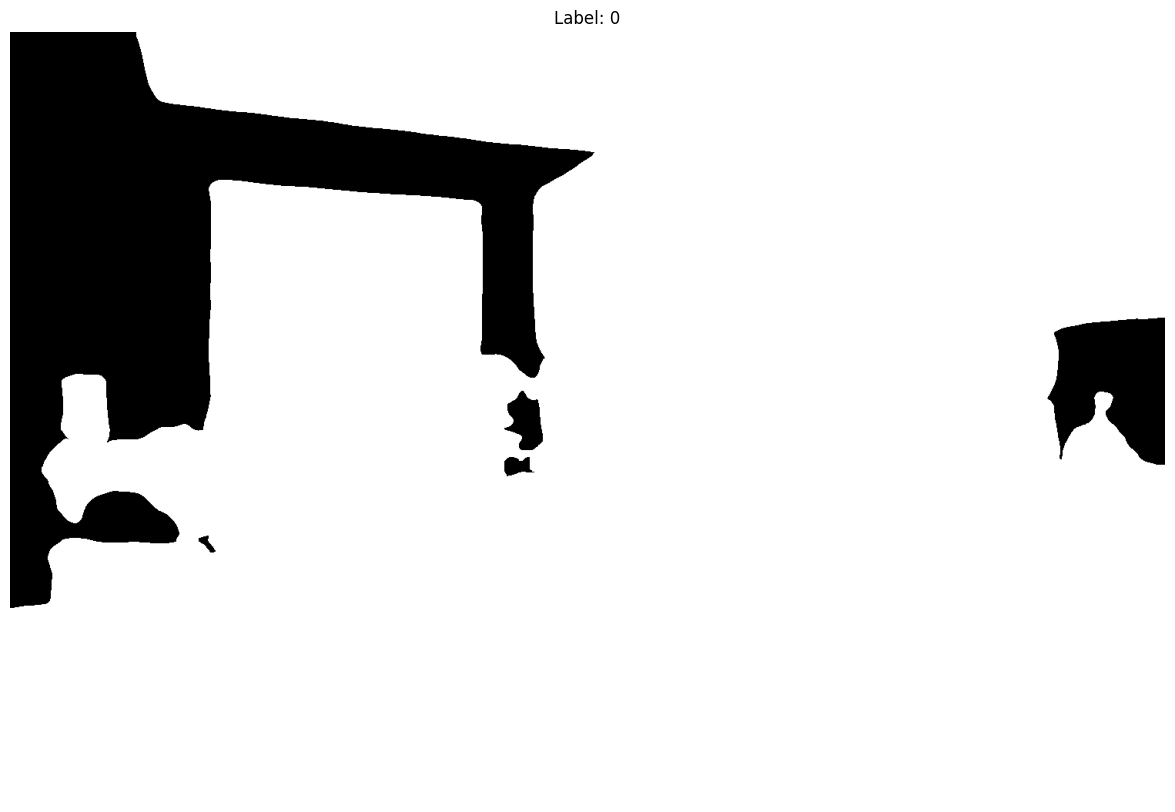

In [80]:
masks, labels = mask_segmentation_map(predicted_semantic_map)

plt.figure(figsize=(15, 10))
plt.axis('off')
plt.title(f"Label: {labels[0]}")
plt.imshow(masks[0], cmap='gray')

In [79]:
masks[0]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)